In [1]:
using Revise
using DifferentialEquations
using Flux
using DiffEqFlux
using Optim
using Plots
using FileIO
using JLD2
using OffsetArrays
using Kinetic

In [2]:
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [12]:
D = read_dict("../code/shock/configminor.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d1f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.95
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = uniform
nxg = 0
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vMeshType = rectangle
knudsen = 0.1
mach = 2.0
prandtl = 1.0
inK = 0.0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
tLen = 3
nh = 12



In [13]:
γ = 3.
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType, nug)
wL, primL, fL, bcL, wR, primR, fR, bcR = ib_rh(mach, γ, vSpace.u)
ib = IB1D1F(wL, primL, fL, bcL, wR, primR, fR, bcR)

ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd());

In [153]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx+1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx÷2
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wL), Float32.(ks.ib.primL), Float32.(ks.ib.fL))
    else
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wR), Float32.(ks.ib.primR), Float32.(ks.ib.fR))
    end
end
for i=1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.wL, ks.ib.fL)
end

In [154]:
sos = sound_speed(ks.ib.primR, γ)
vmax = ks.vSpace.u1 + sos
tmax = vmax / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tSpan = (0.f0, dt)
tRan = range(tSpan[1], tSpan[2], length=tLen)

0.0f0:0.03870998f0:0.07741996f0

In [155]:
residual = Array{Float32}(undef, 3)
for iter=1:2000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [117]:
X = Array{Float32}(undef, nu, nx);
for i in 1:nx
    X[:,i] .= ctr[i].f #.* (1. + 0.01 * randn())
end

In [124]:
M = Array{Float32}(undef, nu, nx)
τ = Array{Float32}(undef, 1, nx)
for i=1:nx
    #w = moments_conserve(X[:,i], ks.vSpace.u, ks.vSpace.weights)
    #prim = conserve_prim(w, ks.gas.γ)
    #M[:,i] .= maxwellian(ks.vSpace.u, prim)
    #τ[i] = vhs_collision_time(prim, ks.gas.μᵣ, ks.gas.ω)
    
    M[:,i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    τ[1,i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end

data_para = [M, τ];

In [125]:
prob = ODEProblem(bgk!, X, tSpan, data_para)
Y = solve(prob, Tsit5(), saveat=tRan) |> Array;

In [126]:
dudt = FastChain( (x, p) -> x.^2,
                   FastDense(vSpace.nu, vSpace.nu*16, tanh),
                   #FastDense(vSpace.nu*16, vSpace.nu*16, tanh),
                   FastDense(vSpace.nu*16, vSpace.nu) )
node = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan);

In [127]:
function loss_node(p) # without dataset
    diff = Array(node(X, p)) .- Y
    loss = sum(abs2, diff)
    return loss
end

loss_node (generic function with 1 method)

In [128]:
cb = function (p, l)
    display(l)
    return false
end

#17 (generic function with 1 method)

In [24]:
res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), cb=cb, maxiters=200)

0.013038646f0

loss: 0.013:   0%|▎                                        |  ETA: 1:43:06

0.0048138597f0

loss: 0.00481:   1%|▍                                        |  ETA: 0:53:25

0.0022048329f0

loss: 0.0022:   2%|▋                                        |  ETA: 0:35:51

0.0024222156f0

loss: 0.00242:   2%|▉                                        |  ETA: 0:27:05

0.003353543f0

loss: 0.00335:   2%|█                                        |  ETA: 0:21:48

0.0037483592f0

loss: 0.00375:   3%|█▎                                       |  ETA: 0:18:21

0.0033491668f0

loss: 0.00335:   4%|█▍                                       |  ETA: 0:15:49

0.0025480653f0

loss: 0.00255:   4%|█▋                                       |  ETA: 0:13:56

0.0018262456f0

loss: 0.00183:   4%|█▉                                       |  ETA: 0:12:24

0.0014713522f0

loss: 0.00147:   5%|██                                       |  ETA: 0:11:14

0.0015069285f0

loss: 0.00151:   6%|██▎                                      |  ETA: 0:10:14

0.0017526951f0

loss: 0.00175:   6%|██▌                                      |  ETA: 0:09:24

0.0019734295f0

loss: 0.00197:   6%|██▋                                      |  ETA: 0:08:44

0.0020167998f0

loss: 0.00202:   7%|██▉                                      |  ETA: 0:08:10

0.0018604709f0

loss: 0.00186:   8%|███▏                                     |  ETA: 0:07:40

0.0015781218f0

loss: 0.00158:   8%|███▎                                     |  ETA: 0:07:13

0.0012804947f0

loss: 0.00128:   8%|███▌                                     |  ETA: 0:06:49

0.0010656533f0

loss: 0.00107:   9%|███▊                                     |  ETA: 0:06:27

0.000983925f0

loss: 0.000984:  10%|███▉                                     |  ETA: 0:06:08

0.001023594f0

loss: 0.00102:  10%|████▏                                    |  ETA: 0:05:50

0.0011259282f0

loss: 0.00113:  10%|████▎                                    |  ETA: 0:05:34

0.0012199203f0

loss: 0.00122:  11%|████▌                                    |  ETA: 0:05:19

0.0012532156f0

loss: 0.00125:  12%|████▊                                    |  ETA: 0:05:06

0.0012074488f0

loss: 0.00121:  12%|████▉                                    |  ETA: 0:04:54

0.0011002035f0

loss: 0.0011:  12%|█████▏                                   |  ETA: 0:04:42

0.00097470556f0

loss: 0.000975:  13%|█████▍                                   |  ETA: 0:04:32

0.0008785173f0

loss: 0.000879:  14%|█████▌                                   |  ETA: 0:04:22

0.00084016524f0

loss: 0.00084:  14%|█████▊                                   |  ETA: 0:04:13

0.0008564228f0

loss: 0.000856:  14%|██████                                   |  ETA: 0:04:05

0.00089786336f0

loss: 0.000898:  15%|██████▏                                  |  ETA: 0:03:57

0.00092897913f0

loss: 0.000929:  16%|██████▍                                  |  ETA: 0:03:49

0.0009281327f0

loss: 0.000928:  16%|██████▌                                  |  ETA: 0:03:42

0.00089430984f0

loss: 0.000894:  16%|██████▊                                  |  ETA: 0:03:36

0.0008413431f0

loss: 0.000841:  17%|███████                                  |  ETA: 0:03:30

0.0007884519f0

loss: 0.000788:  18%|███████▏                                 |  ETA: 0:03:24

0.000752069f0

loss: 0.000752:  18%|███████▍                                 |  ETA: 0:03:18

0.0007394784f0

loss: 0.000739:  18%|███████▋                                 |  ETA: 0:03:13

0.0007462661f0

loss: 0.000746:  19%|███████▊                                 |  ETA: 0:03:08

0.0007598556f0

loss: 0.00076:  20%|████████                                 |  ETA: 0:03:04

0.0007670085f0

loss: 0.000767:  20%|████████▎                                |  ETA: 0:02:59

0.0007601043f0

loss: 0.00076:  20%|████████▍                                |  ETA: 0:02:55

0.0007393217f0

loss: 0.000739:  21%|████████▋                                |  ETA: 0:02:50

0.0007113654f0

loss: 0.000711:  22%|████████▉                                |  ETA: 0:02:47

0.00068576605f0

loss: 0.000686:  22%|█████████                                |  ETA: 0:02:43

0.00066973176f0

loss: 0.00067:  22%|█████████▎                               |  ETA: 0:02:39

0.0006643709f0

loss: 0.000664:  23%|█████████▍                               |  ETA: 0:02:36

0.0006650607f0

loss: 0.000665:  24%|█████████▋                               |  ETA: 0:02:32

0.00066508783f0

loss: 0.000665:  24%|█████████▉                               |  ETA: 0:02:29

0.00065961346f0

loss: 0.00066:  24%|██████████                               |  ETA: 0:02:26

0.00064783805f0

loss: 0.000648:  25%|██████████▎                              |  ETA: 0:02:23

0.0006325663f0

loss: 0.000633:  26%|██████████▌                              |  ETA: 0:02:20

0.0006179336f0

loss: 0.000618:  26%|██████████▋                              |  ETA: 0:02:17

0.0006071957f0

loss: 0.000607:  26%|██████████▉                              |  ETA: 0:02:15

0.00060130196f0

loss: 0.000601:  27%|███████████▏                             |  ETA: 0:02:12

0.0005982858f0

loss: 0.000598:  28%|███████████▎                             |  ETA: 0:02:09

0.0005945066f0

loss: 0.000595:  28%|███████████▌                             |  ETA: 0:02:07

0.000587394f0

loss: 0.000587:  28%|███████████▋                             |  ETA: 0:02:05

0.0005771347f0

loss: 0.000577:  29%|███████████▉                             |  ETA: 0:02:02

0.0005658615f0

loss: 0.000566:  30%|████████████▏                            |  ETA: 0:02:00

0.0005557738f0

loss: 0.000556:  30%|████████████▎                            |  ETA: 0:01:58

0.0005479265f0

loss: 0.000548:  30%|████████████▌                            |  ETA: 0:01:56

0.00054208335f0

loss: 0.000542:  31%|████████████▊                            |  ETA: 0:01:54

0.00053712464f0

loss: 0.000537:  32%|████████████▉                            |  ETA: 0:01:52

0.0005316457f0

loss: 0.000532:  32%|█████████████▏                           |  ETA: 0:01:50

0.0005247103f0

loss: 0.000525:  32%|█████████████▍                           |  ETA: 0:01:48

0.000516408f0

loss: 0.000516:  33%|█████████████▌                           |  ETA: 0:01:46

0.0005077417f0

loss: 0.000508:  34%|█████████████▊                           |  ETA: 0:01:45

0.00049986516f0

loss: 0.0005:  34%|██████████████                           |  ETA: 0:01:43

0.00049325003f0

loss: 0.000493:  34%|██████████████▏                          |  ETA: 0:01:41

0.0004874834f0

loss: 0.000487:  35%|██████████████▍                          |  ETA: 0:01:39

0.00048172454f0

loss: 0.000482:  36%|██████████████▌                          |  ETA: 0:01:38

0.00047533412f0

loss: 0.000475:  36%|██████████████▊                          |  ETA: 0:01:36

0.00046824117f0

loss: 0.000468:  36%|███████████████                          |  ETA: 0:01:35

0.0004608831f0

loss: 0.000461:  37%|███████████████▏                         |  ETA: 0:01:33

0.0004538605f0

loss: 0.000454:  38%|███████████████▍                         |  ETA: 0:01:32

0.0004475128f0

loss: 0.000448:  38%|███████████████▋                         |  ETA: 0:01:30

0.00044172007f0

loss: 0.000442:  38%|███████████████▊                         |  ETA: 0:01:29

0.0004360504f0

loss: 0.000436:  39%|████████████████                         |  ETA: 0:01:28

0.00043008872f0

loss: 0.00043:  40%|████████████████▎                        |  ETA: 0:01:26

0.00042371204f0

loss: 0.000424:  40%|████████████████▍                        |  ETA: 0:01:25

0.00041714925f0

loss: 0.000417:  40%|████████████████▋                        |  ETA: 0:01:23

0.00041075377f0

loss: 0.000411:  41%|████████████████▊                        |  ETA: 0:01:22

0.00040473562f0

loss: 0.000405:  42%|█████████████████                        |  ETA: 0:01:21

0.000399064f0

loss: 0.000399:  42%|█████████████████▎                       |  ETA: 0:01:20

0.00039353967f0

loss: 0.000394:  42%|█████████████████▍                       |  ETA: 0:01:18

0.00038795848f0

loss: 0.000388:  43%|█████████████████▋                       |  ETA: 0:01:17

0.00038222922f0

loss: 0.000382:  44%|█████████████████▉                       |  ETA: 0:01:16

0.00037642237f0

loss: 0.000376:  44%|██████████████████                       |  ETA: 0:01:15

0.00037069613f0

loss: 0.000371:  44%|██████████████████▎                      |  ETA: 0:01:14

0.00036517534f0

loss: 0.000365:  45%|██████████████████▌                      |  ETA: 0:01:13

0.00035986185f0

loss: 0.00036:  46%|██████████████████▋                      |  ETA: 0:01:12

0.00035465465f0

loss: 0.000355:  46%|██████████████████▉                      |  ETA: 0:01:11

0.00034943753f0

loss: 0.000349:  46%|███████████████████▏                     |  ETA: 0:01:09

0.00034418487f0

loss: 0.000344:  47%|███████████████████▎                     |  ETA: 0:01:08

0.0003389636f0

loss: 0.000339:  48%|███████████████████▌                     |  ETA: 0:01:07

0.0003338619f0

loss: 0.000334:  48%|███████████████████▋                     |  ETA: 0:01:06

0.00032891164f0

loss: 0.000329:  48%|███████████████████▉                     |  ETA: 0:01:05

0.00032408026f0

loss: 0.000324:  49%|████████████████████▏                    |  ETA: 0:01:04

0.00031930627f0

loss: 0.000319:  50%|████████████████████▎                    |  ETA: 0:01:03

0.00031455548f0

loss: 0.000315:  50%|████████████████████▌                    |  ETA: 0:01:03

0.0003098343f0

loss: 0.00031:  50%|████████████████████▊                    |  ETA: 0:01:02

0.00030518547f0

loss: 0.000305:  51%|████████████████████▉                    |  ETA: 0:01:01

0.00030065002f0

loss: 0.000301:  52%|█████████████████████▏                   |  ETA: 0:01:00

0.00029623724f0

loss: 0.000296:  52%|█████████████████████▍                   |  ETA: 0:00:59

0.0002919113f0

loss: 0.000292:  52%|█████████████████████▌                   |  ETA: 0:00:58

0.0002876368f0

loss: 0.000288:  53%|█████████████████████▊                   |  ETA: 0:00:57

0.00028340472f0

loss: 0.000283:  54%|█████████████████████▉                   |  ETA: 0:00:56

0.0002792349f0

loss: 0.000279:  54%|██████████████████████▏                  |  ETA: 0:00:55

0.00027515023f0

loss: 0.000275:  54%|██████████████████████▍                  |  ETA: 0:00:54

0.00027116569f0

loss: 0.000271:  55%|██████████████████████▌                  |  ETA: 0:00:54

0.00026727747f0

loss: 0.000267:  56%|██████████████████████▊                  |  ETA: 0:00:53

0.00026346187f0

loss: 0.000263:  56%|███████████████████████                  |  ETA: 0:00:52

0.00025970026f0

loss: 0.00026:  56%|███████████████████████▏                 |  ETA: 0:00:51

0.00025599392f0

loss: 0.000256:  57%|███████████████████████▍                 |  ETA: 0:00:50

0.00025236484f0

loss: 0.000252:  58%|███████████████████████▋                 |  ETA: 0:00:49

0.0002488208f0

loss: 0.000249:  58%|███████████████████████▊                 |  ETA: 0:00:49

0.00024536048f0

loss: 0.000245:  58%|████████████████████████                 |  ETA: 0:00:48

0.00024197475f0

loss: 0.000242:  59%|████████████████████████▎                |  ETA: 0:00:47

0.00023865141f0

loss: 0.000239:  60%|████████████████████████▍                |  ETA: 0:00:46

0.00023538855f0

loss: 0.000235:  60%|████████████████████████▋                |  ETA: 0:00:46

0.00023219224f0

loss: 0.000232:  60%|████████████████████████▊                |  ETA: 0:00:45

0.00022906708f0

loss: 0.000229:  61%|█████████████████████████                |  ETA: 0:00:44

0.00022601616f0

loss: 0.000226:  62%|█████████████████████████▎               |  ETA: 0:00:43

0.0002230342f0

loss: 0.000223:  62%|█████████████████████████▍               |  ETA: 0:00:43

0.00022011247f0

loss: 0.00022:  62%|█████████████████████████▋               |  ETA: 0:00:42

0.00021724898f0

loss: 0.000217:  63%|█████████████████████████▉               |  ETA: 0:00:41

0.00021444619f0

loss: 0.000214:  64%|██████████████████████████               |  ETA: 0:00:41

0.00021170639f0

loss: 0.000212:  64%|██████████████████████████▎              |  ETA: 0:00:40

0.00020903026f0

loss: 0.000209:  64%|██████████████████████████▌              |  ETA: 0:00:39

0.00020641528f0

loss: 0.000206:  65%|██████████████████████████▋              |  ETA: 0:00:38

0.00020385474f0

loss: 0.000204:  66%|██████████████████████████▉              |  ETA: 0:00:38

0.00020134702f0

loss: 0.000201:  66%|███████████████████████████              |  ETA: 0:00:37

0.00019889242f0

loss: 0.000199:  66%|███████████████████████████▎             |  ETA: 0:00:36

0.00019649195f0

loss: 0.000196:  67%|███████████████████████████▌             |  ETA: 0:00:36

0.00019414505f0

loss: 0.000194:  68%|███████████████████████████▋             |  ETA: 0:00:35

0.00019184983f0

loss: 0.000192:  68%|███████████████████████████▉             |  ETA: 0:00:34

0.0001896036f0

loss: 0.00019:  68%|████████████████████████████▏            |  ETA: 0:00:34

0.00018740253f0

loss: 0.000187:  69%|████████████████████████████▎            |  ETA: 0:00:33

0.0001852481f0

loss: 0.000185:  70%|████████████████████████████▌            |  ETA: 0:00:33

0.00018313932f0

loss: 0.000183:  70%|████████████████████████████▊            |  ETA: 0:00:32

0.00018107539f0

loss: 0.000181:  70%|████████████████████████████▉            |  ETA: 0:00:31

0.00017905454f0

loss: 0.000179:  71%|█████████████████████████████▏           |  ETA: 0:00:31

0.00017707405f0

loss: 0.000177:  72%|█████████████████████████████▍           |  ETA: 0:00:30

0.00017513198f0

loss: 0.000175:  72%|█████████████████████████████▌           |  ETA: 0:00:29

0.00017322916f0

loss: 0.000173:  72%|█████████████████████████████▊           |  ETA: 0:00:29

0.0001713647f0

loss: 0.000171:  73%|█████████████████████████████▉           |  ETA: 0:00:28

0.00016953613f0

loss: 0.00017:  74%|██████████████████████████████▏          |  ETA: 0:00:28

0.00016774383f0

loss: 0.000168:  74%|██████████████████████████████▍          |  ETA: 0:00:27

0.00016598534f0

loss: 0.000166:  74%|██████████████████████████████▌          |  ETA: 0:00:26

0.00016425853f0

loss: 0.000164:  75%|██████████████████████████████▊          |  ETA: 0:00:26

0.00016256448f0

loss: 0.000163:  76%|███████████████████████████████          |  ETA: 0:00:25

0.00016090178f0

loss: 0.000161:  76%|███████████████████████████████▏         |  ETA: 0:00:25

0.00015926875f0

loss: 0.000159:  76%|███████████████████████████████▍         |  ETA: 0:00:24

0.00015766465f0

loss: 0.000158:  77%|███████████████████████████████▋         |  ETA: 0:00:24

0.00015608889f0

loss: 0.000156:  78%|███████████████████████████████▊         |  ETA: 0:00:23

0.0001545402f0

loss: 0.000155:  78%|████████████████████████████████         |  ETA: 0:00:22

0.00015301775f0

loss: 0.000153:  78%|████████████████████████████████▏        |  ETA: 0:00:22

0.00015152153f0

loss: 0.000152:  79%|████████████████████████████████▍        |  ETA: 0:00:21

0.00015004989f0

loss: 0.00015:  80%|████████████████████████████████▋        |  ETA: 0:00:21

0.00014860206f0

loss: 0.000149:  80%|████████████████████████████████▊        |  ETA: 0:00:20

0.00014717838f0

loss: 0.000147:  80%|█████████████████████████████████        |  ETA: 0:00:20

0.00014577681f0

loss: 0.000146:  81%|█████████████████████████████████▎       |  ETA: 0:00:19

0.00014439772f0

loss: 0.000144:  82%|█████████████████████████████████▍       |  ETA: 0:00:19

0.00014304042f0

loss: 0.000143:  82%|█████████████████████████████████▋       |  ETA: 0:00:18

0.00014170333f0

loss: 0.000142:  82%|█████████████████████████████████▉       |  ETA: 0:00:17

0.0001403871f0

loss: 0.00014:  83%|██████████████████████████████████       |  ETA: 0:00:17

0.00013909099f0

loss: 0.000139:  84%|██████████████████████████████████▎      |  ETA: 0:00:16

0.00013781394f0

loss: 0.000138:  84%|██████████████████████████████████▌      |  ETA: 0:00:16

0.00013655619f0

loss: 0.000137:  84%|██████████████████████████████████▋      |  ETA: 0:00:15

0.00013531628f0

loss: 0.000135:  85%|██████████████████████████████████▉      |  ETA: 0:00:15

0.00013409543f0

loss: 0.000134:  86%|███████████████████████████████████      |  ETA: 0:00:14

0.00013289222f0

loss: 0.000133:  86%|███████████████████████████████████▎     |  ETA: 0:00:14

0.00013170597f0

loss: 0.000132:  86%|███████████████████████████████████▌     |  ETA: 0:00:13

0.00013053659f0

loss: 0.000131:  87%|███████████████████████████████████▋     |  ETA: 0:00:13

0.00012938386f0

loss: 0.000129:  88%|███████████████████████████████████▉     |  ETA: 0:00:12

0.0001282487f0

loss: 0.000128:  88%|████████████████████████████████████▏    |  ETA: 0:00:12

0.00012712891f0

loss: 0.000127:  88%|████████████████████████████████████▎    |  ETA: 0:00:11

0.00012602466f0

loss: 0.000126:  89%|████████████████████████████████████▌    |  ETA: 0:00:11

0.00012493646f0

loss: 0.000125:  90%|████████████████████████████████████▊    |  ETA: 0:00:10

0.00012386378f0

loss: 0.000124:  90%|████████████████████████████████████▉    |  ETA: 0:00:10

0.00012280607f0

loss: 0.000123:  90%|█████████████████████████████████████▏   |  ETA: 0:00:09

0.00012176379f0

loss: 0.000122:  91%|█████████████████████████████████████▎   |  ETA: 0:00:09

0.00012073516f0

loss: 0.000121:  92%|█████████████████████████████████████▌   |  ETA: 0:00:08

0.00011972163f0

loss: 0.00012:  92%|█████████████████████████████████████▊   |  ETA: 0:00:08

0.000118723154f0

loss: 0.000119:  92%|█████████████████████████████████████▉   |  ETA: 0:00:07

0.000117738484f0

loss: 0.000118:  93%|██████████████████████████████████████▏  |  ETA: 0:00:07

0.0001167673f0

loss: 0.000117:  94%|██████████████████████████████████████▍  |  ETA: 0:00:06

0.00011580967f0

loss: 0.000116:  94%|██████████████████████████████████████▌  |  ETA: 0:00:06

0.000114866736f0

loss: 0.000115:  94%|██████████████████████████████████████▊  |  ETA: 0:00:05

0.00011393679f0

loss: 0.000114:  95%|███████████████████████████████████████  |  ETA: 0:00:05

0.00011302026f0

loss: 0.000113:  96%|███████████████████████████████████████▏ |  ETA: 0:00:04

0.00011211766f0

loss: 0.000112:  96%|███████████████████████████████████████▍ |  ETA: 0:00:04

0.00011122794f0

loss: 0.000111:  96%|███████████████████████████████████████▋ |  ETA: 0:00:03

0.00011035039f0

loss: 0.00011:  97%|███████████████████████████████████████▊ |  ETA: 0:00:03

0.00010948644f0

loss: 0.000109:  98%|████████████████████████████████████████ |  ETA: 0:00:02

0.00010863507f0

loss: 0.000109:  98%|████████████████████████████████████████▏|  ETA: 0:00:02

0.00010779644f0

loss: 0.000108:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

0.000106969674f0

loss: 0.000107:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

0.000106156f0

loss: 0.000106: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

0.00010535408f0

loss: 0.000105: 100%|█████████████████████████████████████████| Time: 0:01:32


0.00010535408f0

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [2.38e-02, 4.39e-02, -3.04e-02,  ...]
    Minimum:   1.053541e-04

 * Found with
    Algorithm:     ADAM
    Initial Point: [2.40e-02, 4.19e-02, -3.20e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   94  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [129]:
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), cb=cb, maxiters=400)

0.7034557f0

loss: 0.703:   0%|▏                                        |  ETA: 1:04:21

0.56941056f0

loss: 0.569:   0%|▎                                        |  ETA: 0:28:57

0.45377985f0

loss: 0.454:   1%|▎                                        |  ETA: 0:22:42

0.35638735f0

loss: 0.356:   1%|▍                                        |  ETA: 0:17:31

0.27503812f0

loss: 0.275:   1%|▌                                        |  ETA: 0:15:43

0.20784998f0

loss: 0.208:   2%|▋                                        |  ETA: 0:13:23

0.15355377f0

loss: 0.154:   2%|▊                                        |  ETA: 0:12:36

0.11099189f0

loss: 0.111:   2%|▉                                        |  ETA: 0:11:24

0.07880264f0

loss: 0.0788:   2%|▉                                        |  ETA: 0:11:00

0.0555083f0

loss: 0.0555:   2%|█                                        |  ETA: 0:10:10

0.039740168f0

loss: 0.0397:   3%|█▏                                       |  ETA: 0:09:54

0.030061677f0

loss: 0.0301:   3%|█▎                                       |  ETA: 0:09:13

0.025109163f0

loss: 0.0251:   3%|█▎                                       |  ETA: 0:09:00

0.023523832f0

loss: 0.0235:   4%|█▍                                       |  ETA: 0:08:31

0.024054836f0

loss: 0.0241:   4%|█▌                                       |  ETA: 0:08:24

0.02565813f0

loss: 0.0257:   4%|█▋                                       |  ETA: 0:08:00

0.027532429f0

loss: 0.0275:   4%|█▊                                       |  ETA: 0:07:53

0.029106436f0

loss: 0.0291:   4%|█▉                                       |  ETA: 0:07:37

0.03001881f0

loss: 0.03:   5%|█▉                                       |  ETA: 0:07:30

0.03010069f0

loss: 0.0301:   5%|██                                       |  ETA: 0:07:18

0.029343635f0

loss: 0.0293:   5%|██▏                                      |  ETA: 0:07:15

0.027851177f0

loss: 0.0279:   6%|██▎                                      |  ETA: 0:07:03

0.02580445f0

loss: 0.0258:   6%|██▍                                      |  ETA: 0:06:59

0.023426192f0

loss: 0.0234:   6%|██▌                                      |  ETA: 0:06:48

0.020939836f0

loss: 0.0209:   6%|██▌                                      |  ETA: 0:06:45

0.018532274f0

loss: 0.0185:   6%|██▋                                      |  ETA: 0:06:36

0.016342033f0

loss: 0.0163:   7%|██▊                                      |  ETA: 0:06:34

0.014464332f0

loss: 0.0145:   7%|██▉                                      |  ETA: 0:06:26

0.012930998f0

loss: 0.0129:   7%|███                                      |  ETA: 0:06:23

0.011720173f0

loss: 0.0117:   8%|███▏                                     |  ETA: 0:06:16

0.010779961f0

loss: 0.0108:   8%|███▏                                     |  ETA: 0:06:11

0.010033503f0

loss: 0.01:   8%|███▎                                     |  ETA: 0:06:06

0.009404944f0

loss: 0.0094:   8%|███▍                                     |  ETA: 0:06:03

0.008829209f0

loss: 0.00883:   8%|███▌                                     |  ETA: 0:05:56

0.008260374f0

loss: 0.00826:   9%|███▋                                     |  ETA: 0:05:55

0.00767506f0

loss: 0.00768:   9%|███▊                                     |  ETA: 0:05:48

0.0070703304f0

loss: 0.00707:   9%|███▊                                     |  ETA: 0:05:47

0.0064603416f0

loss: 0.00646:  10%|███▉                                     |  ETA: 0:05:41

0.005871166f0

loss: 0.00587:  10%|████                                     |  ETA: 0:05:40

0.0053327796f0

loss: 0.00533:  10%|████▏                                    |  ETA: 0:05:35

0.004870674f0

loss: 0.00487:  10%|████▏                                    |  ETA: 0:05:33

0.0045008743f0

loss: 0.0045:  10%|████▎                                    |  ETA: 0:05:27

0.004228758f0

loss: 0.00423:  11%|████▍                                    |  ETA: 0:05:26

0.004049924f0

loss: 0.00405:  11%|████▌                                    |  ETA: 0:05:20

0.003951168f0

loss: 0.00395:  11%|████▋                                    |  ETA: 0:05:19

0.0039127334f0

loss: 0.00391:  12%|████▊                                    |  ETA: 0:05:14

0.003912174f0

loss: 0.00391:  12%|████▊                                    |  ETA: 0:05:13

0.0039283573f0

loss: 0.00393:  12%|████▉                                    |  ETA: 0:05:09

0.003944515f0

loss: 0.00394:  12%|█████                                    |  ETA: 0:05:06

0.003949427f0

loss: 0.00395:  12%|█████▏                                   |  ETA: 0:05:02

0.0039371606f0

loss: 0.00394:  13%|█████▎                                   |  ETA: 0:05:01

0.0039059208f0

loss: 0.00391:  13%|█████▍                                   |  ETA: 0:04:57

0.003856916f0

loss: 0.00386:  13%|█████▍                                   |  ETA: 0:04:55

0.0037933677f0

loss: 0.00379:  14%|█████▌                                   |  ETA: 0:04:52

0.0037189457f0

loss: 0.00372:  14%|█████▋                                   |  ETA: 0:04:51

0.0036371134f0

loss: 0.00364:  14%|█████▊                                   |  ETA: 0:04:48

0.0035512086f0

loss: 0.00355:  14%|█████▉                                   |  ETA: 0:04:47

0.0034645693f0

loss: 0.00346:  14%|██████                                   |  ETA: 0:04:42

0.0033804462f0

loss: 0.00338:  15%|██████                                   |  ETA: 0:04:41

0.003301508f0

loss: 0.0033:  15%|██████▏                                  |  ETA: 0:04:37

0.0032299468f0

loss: 0.00323:  15%|██████▎                                  |  ETA: 0:04:35

0.003167471f0

loss: 0.00317:  16%|██████▍                                  |  ETA: 0:04:34

0.00311498f0

loss: 0.00311:  16%|██████▍                                  |  ETA: 0:04:34

0.0030723908f0

loss: 0.00307:  16%|██████▌                                  |  ETA: 0:04:31

0.0030388355f0

loss: 0.00304:  16%|██████▋                                  |  ETA: 0:04:29

0.0030128746f0

loss: 0.00301:  16%|██████▊                                  |  ETA: 0:04:26

0.0029925962f0

loss: 0.00299:  17%|██████▉                                  |  ETA: 0:04:24

0.0029765423f0

loss: 0.00298:  17%|███████                                  |  ETA: 0:04:20

0.0029633478f0

loss: 0.00296:  17%|███████                                  |  ETA: 0:04:19

0.0029520746f0

loss: 0.00295:  18%|███████▏                                 |  ETA: 0:04:16

0.002942189f0

loss: 0.00294:  18%|███████▎                                 |  ETA: 0:04:14

0.002933302f0

loss: 0.00293:  18%|███████▍                                 |  ETA: 0:04:11

0.0029253133f0

loss: 0.00293:  18%|███████▌                                 |  ETA: 0:04:10

0.002918045f0

loss: 0.00292:  18%|███████▋                                 |  ETA: 0:04:07

0.0029113642f0

loss: 0.00291:  19%|███████▋                                 |  ETA: 0:04:06

0.002904912f0

loss: 0.0029:  19%|███████▊                                 |  ETA: 0:04:03

0.002898431f0

loss: 0.0029:  19%|███████▉                                 |  ETA: 0:04:02

0.0028916718f0

loss: 0.00289:  20%|████████                                 |  ETA: 0:03:59

0.0028844443f0

loss: 0.00288:  20%|████████▏                                |  ETA: 0:03:57

0.002876595f0

loss: 0.00288:  20%|████████▎                                |  ETA: 0:03:55

0.0028680915f0

loss: 0.00287:  20%|████████▎                                |  ETA: 0:03:54

0.0028590008f0

loss: 0.00286:  20%|████████▍                                |  ETA: 0:03:51

0.0028494813f0

loss: 0.00285:  21%|████████▌                                |  ETA: 0:03:50

0.0028396053f0

loss: 0.00284:  21%|████████▋                                |  ETA: 0:03:48

0.0028295768f0

loss: 0.00283:  21%|████████▊                                |  ETA: 0:03:46

0.0028195106f0

loss: 0.00282:  22%|████████▉                                |  ETA: 0:03:44

0.0028095888f0

loss: 0.00281:  22%|████████▉                                |  ETA: 0:03:43

0.0028001764f0

loss: 0.0028:  22%|█████████                                |  ETA: 0:03:41

0.0027915372f0

loss: 0.00279:  22%|█████████▏                               |  ETA: 0:03:40

0.0027839765f0

loss: 0.00278:  22%|█████████▎                               |  ETA: 0:03:38

0.0027776975f0

loss: 0.00278:  23%|█████████▎                               |  ETA: 0:03:37

0.002772765f0

loss: 0.00277:  23%|█████████▍                               |  ETA: 0:03:35

0.0027690986f0

loss: 0.00277:  23%|█████████▌                               |  ETA: 0:03:34

0.0027663661f0

loss: 0.00277:  24%|█████████▋                               |  ETA: 0:03:32

0.0027642436f0

loss: 0.00276:  24%|█████████▊                               |  ETA: 0:03:31

0.0027622073f0

loss: 0.00276:  24%|█████████▉                               |  ETA: 0:03:29

0.0027598874f0

loss: 0.00276:  24%|█████████▉                               |  ETA: 0:03:28

0.0027569358f0

loss: 0.00276:  24%|██████████                               |  ETA: 0:03:26

0.0027532084f0

loss: 0.00275:  25%|██████████▏                              |  ETA: 0:03:25

0.0027487103f0

loss: 0.00275:  25%|██████████▎                              |  ETA: 0:03:23

0.002743574f0

loss: 0.00274:  25%|██████████▍                              |  ETA: 0:03:23

0.002738016f0

loss: 0.00274:  26%|██████████▌                              |  ETA: 0:03:21

0.0027323533f0

loss: 0.00273:  26%|██████████▌                              |  ETA: 0:03:20

0.0027267118f0

loss: 0.00273:  26%|██████████▋                              |  ETA: 0:03:18

0.00272139f0

loss: 0.00272:  26%|██████████▊                              |  ETA: 0:03:17

0.0027163627f0

loss: 0.00272:  26%|██████████▉                              |  ETA: 0:03:15

0.0027117305f0

loss: 0.00271:  27%|███████████                              |  ETA: 0:03:15

0.002707413f0

loss: 0.00271:  27%|███████████▏                             |  ETA: 0:03:13

0.0027033186f0

loss: 0.0027:  27%|███████████▏                             |  ETA: 0:03:12

0.0026993155f0

loss: 0.0027:  28%|███████████▎                             |  ETA: 0:03:11

0.002695337f0

loss: 0.0027:  28%|███████████▍                             |  ETA: 0:03:10

0.0026913704f0

loss: 0.00269:  28%|███████████▌                             |  ETA: 0:03:08

0.0026873138f0

loss: 0.00269:  28%|███████████▌                             |  ETA: 0:03:08

0.002683125f0

loss: 0.00268:  28%|███████████▋                             |  ETA: 0:03:06

0.0026788963f0

loss: 0.00268:  29%|███████████▊                             |  ETA: 0:03:05

0.0026746131f0

loss: 0.00267:  29%|███████████▉                             |  ETA: 0:03:04

0.0026702837f0

loss: 0.00267:  29%|████████████                             |  ETA: 0:03:03

0.0026659863f0

loss: 0.00267:  30%|████████████▏                            |  ETA: 0:03:01

0.0026617085f0

loss: 0.00266:  30%|████████████▏                            |  ETA: 0:03:01

0.0026574426f0

loss: 0.00266:  30%|████████████▎                            |  ETA: 0:02:59

0.0026532311f0

loss: 0.00265:  30%|████████████▍                            |  ETA: 0:02:59

0.0026490246f0

loss: 0.00265:  30%|████████████▌                            |  ETA: 0:02:57

0.002644801f0

loss: 0.00264:  31%|████████████▋                            |  ETA: 0:02:57

0.0026405847f0

loss: 0.00264:  31%|████████████▊                            |  ETA: 0:02:55

0.0026363095f0

loss: 0.00264:  31%|████████████▊                            |  ETA: 0:02:55

0.0026320138f0

loss: 0.00263:  32%|████████████▉                            |  ETA: 0:02:53

0.0026276843f0

loss: 0.00263:  32%|█████████████                            |  ETA: 0:02:53

0.00262335f0

loss: 0.00262:  32%|█████████████▏                           |  ETA: 0:02:51

0.002618994f0

loss: 0.00262:  32%|█████████████▎                           |  ETA: 0:02:50

0.0026146662f0

loss: 0.00261:  32%|█████████████▍                           |  ETA: 0:02:49

0.0026103011f0

loss: 0.00261:  33%|█████████████▍                           |  ETA: 0:02:48

0.00260599f0

loss: 0.00261:  33%|█████████████▌                           |  ETA: 0:02:47

0.002601646f0

loss: 0.0026:  33%|█████████████▋                           |  ETA: 0:02:47

0.0025973255f0

loss: 0.0026:  34%|█████████████▊                           |  ETA: 0:02:45

0.002592994f0

loss: 0.00259:  34%|█████████████▉                           |  ETA: 0:02:45

0.0025886903f0

loss: 0.00259:  34%|██████████████                           |  ETA: 0:02:44

0.002584349f0

loss: 0.00258:  34%|██████████████                           |  ETA: 0:02:43

0.0025800257f0

loss: 0.00258:  34%|██████████████▏                          |  ETA: 0:02:42

0.002575661f0

loss: 0.00258:  35%|██████████████▎                          |  ETA: 0:02:41

0.0025712962f0

loss: 0.00257:  35%|██████████████▍                          |  ETA: 0:02:40

0.0025669218f0

loss: 0.00257:  35%|██████████████▍                          |  ETA: 0:02:39

0.0025625194f0

loss: 0.00256:  36%|██████████████▌                          |  ETA: 0:02:38

0.0025580938f0

loss: 0.00256:  36%|██████████████▋                          |  ETA: 0:02:37

0.0025537137f0

loss: 0.00255:  36%|██████████████▊                          |  ETA: 0:02:36

0.0025492655f0

loss: 0.00255:  36%|██████████████▉                          |  ETA: 0:02:36

0.0025448422f0

loss: 0.00254:  36%|███████████████                          |  ETA: 0:02:35

0.0025403698f0

loss: 0.00254:  37%|███████████████                          |  ETA: 0:02:34

0.0025359374f0

loss: 0.00254:  37%|███████████████▏                         |  ETA: 0:02:33

0.0025314924f0

loss: 0.00253:  37%|███████████████▎                         |  ETA: 0:02:32

0.002527031f0

loss: 0.00253:  38%|███████████████▍                         |  ETA: 0:02:31

0.002522566f0

loss: 0.00252:  38%|███████████████▌                         |  ETA: 0:02:30

0.0025180986f0

loss: 0.00252:  38%|███████████████▋                         |  ETA: 0:02:29

0.0025136292f0

loss: 0.00251:  38%|███████████████▋                         |  ETA: 0:02:29

0.0025091523f0

loss: 0.00251:  38%|███████████████▊                         |  ETA: 0:02:27

0.0025046486f0

loss: 0.0025:  39%|███████████████▉                         |  ETA: 0:02:27

0.0025001715f0

loss: 0.0025:  39%|████████████████                         |  ETA: 0:02:26

0.0024956593f0

loss: 0.0025:  39%|████████████████▏                        |  ETA: 0:02:25

0.0024911182f0

loss: 0.00249:  40%|████████████████▎                        |  ETA: 0:02:24

0.0024866245f0

loss: 0.00249:  40%|████████████████▎                        |  ETA: 0:02:24

0.002482102f0

loss: 0.00248:  40%|████████████████▍                        |  ETA: 0:02:22

0.0024775676f0

loss: 0.00248:  40%|████████████████▌                        |  ETA: 0:02:22

0.0024730405f0

loss: 0.00247:  40%|████████████████▋                        |  ETA: 0:02:21

0.0024685012f0

loss: 0.00247:  41%|████████████████▋                        |  ETA: 0:02:20

0.0024639578f0

loss: 0.00246:  41%|████████████████▊                        |  ETA: 0:02:19

0.0024593982f0

loss: 0.00246:  41%|████████████████▉                        |  ETA: 0:02:19

0.0024548087f0

loss: 0.00245:  42%|█████████████████                        |  ETA: 0:02:18

0.0024502482f0

loss: 0.00245:  42%|█████████████████▏                       |  ETA: 0:02:17

0.0024456866f0

loss: 0.00245:  42%|█████████████████▎                       |  ETA: 0:02:16

0.0024411022f0

loss: 0.00244:  42%|█████████████████▎                       |  ETA: 0:02:16

0.0024365007f0

loss: 0.00244:  42%|█████████████████▍                       |  ETA: 0:02:15

0.0024319096f0

loss: 0.00243:  43%|█████████████████▌                       |  ETA: 0:02:14

0.002427346f0

loss: 0.00243:  43%|█████████████████▋                       |  ETA: 0:02:13

0.0024227542f0

loss: 0.00242:  43%|█████████████████▊                       |  ETA: 0:02:13

0.0024181353f0

loss: 0.00242:  44%|█████████████████▉                       |  ETA: 0:02:12

0.0024135003f0

loss: 0.00241:  44%|█████████████████▉                       |  ETA: 0:02:11

0.0024089161f0

loss: 0.00241:  44%|██████████████████                       |  ETA: 0:02:10

0.0024042805f0

loss: 0.0024:  44%|██████████████████▏                      |  ETA: 0:02:10

0.0023996483f0

loss: 0.0024:  44%|██████████████████▎                      |  ETA: 0:02:09

0.0023950227f0

loss: 0.0024:  45%|██████████████████▍                      |  ETA: 0:02:08

0.002390393f0

loss: 0.00239:  45%|██████████████████▌                      |  ETA: 0:02:07

0.0023857437f0

loss: 0.00239:  45%|██████████████████▌                      |  ETA: 0:02:07

0.0023811152f0

loss: 0.00238:  46%|██████████████████▋                      |  ETA: 0:02:06

0.0023764751f0

loss: 0.00238:  46%|██████████████████▊                      |  ETA: 0:02:05

0.0023718085f0

loss: 0.00237:  46%|██████████████████▉                      |  ETA: 0:02:04

0.0023671496f0

loss: 0.00237:  46%|███████████████████                      |  ETA: 0:02:04

0.0023624753f0

loss: 0.00236:  46%|███████████████████▏                     |  ETA: 0:02:03

0.0023578256f0

loss: 0.00236:  47%|███████████████████▏                     |  ETA: 0:02:03

0.0023531513f0

loss: 0.00235:  47%|███████████████████▎                     |  ETA: 0:02:02

0.0023484817f0

loss: 0.00235:  47%|███████████████████▍                     |  ETA: 0:02:01

0.0023438036f0

loss: 0.00234:  48%|███████████████████▌                     |  ETA: 0:02:00

0.0023391235f0

loss: 0.00234:  48%|███████████████████▌                     |  ETA: 0:02:00

0.0023344334f0

loss: 0.00233:  48%|███████████████████▋                     |  ETA: 0:01:59

0.002329708f0

loss: 0.00233:  48%|███████████████████▊                     |  ETA: 0:01:58

0.0023250403f0

loss: 0.00233:  48%|███████████████████▉                     |  ETA: 0:01:57

0.002320345f0

loss: 0.00232:  49%|████████████████████                     |  ETA: 0:01:57

0.002315634f0

loss: 0.00232:  49%|████████████████████▏                    |  ETA: 0:01:56

0.0023109405f0

loss: 0.00231:  49%|████████████████████▏                    |  ETA: 0:01:56

0.0023062334f0

loss: 0.00231:  50%|████████████████████▎                    |  ETA: 0:01:55

0.0023015414f0

loss: 0.0023:  50%|████████████████████▍                    |  ETA: 0:01:54

0.0022968117f0

loss: 0.0023:  50%|████████████████████▌                    |  ETA: 0:01:53

0.002292092f0

loss: 0.00229:  50%|████████████████████▋                    |  ETA: 0:01:53

0.0022873827f0

loss: 0.00229:  50%|████████████████████▊                    |  ETA: 0:01:52

0.0022826516f0

loss: 0.00228:  51%|████████████████████▊                    |  ETA: 0:01:52

0.002277929f0

loss: 0.00228:  51%|████████████████████▉                    |  ETA: 0:01:51

0.0022732283f0

loss: 0.00227:  51%|█████████████████████                    |  ETA: 0:01:50

0.0022684743f0

loss: 0.00227:  52%|█████████████████████▏                   |  ETA: 0:01:49

0.0022637697f0

loss: 0.00226:  52%|█████████████████████▎                   |  ETA: 0:01:49

0.002259012f0

loss: 0.00226:  52%|█████████████████████▍                   |  ETA: 0:01:48

0.0022542826f0

loss: 0.00225:  52%|█████████████████████▍                   |  ETA: 0:01:48

0.002249544f0

loss: 0.00225:  52%|█████████████████████▌                   |  ETA: 0:01:47

0.00224479f0

loss: 0.00224:  53%|█████████████████████▋                   |  ETA: 0:01:46

0.0022400662f0

loss: 0.00224:  53%|█████████████████████▊                   |  ETA: 0:01:45

0.002235331f0

loss: 0.00224:  53%|█████████████████████▊                   |  ETA: 0:01:45

0.002230568f0

loss: 0.00223:  54%|█████████████████████▉                   |  ETA: 0:01:44

0.002225824f0

loss: 0.00223:  54%|██████████████████████                   |  ETA: 0:01:44

0.0022210814f0

loss: 0.00222:  54%|██████████████████████▏                  |  ETA: 0:01:43

0.0022163137f0

loss: 0.00222:  54%|██████████████████████▎                  |  ETA: 0:01:42

0.0022115847f0

loss: 0.00221:  54%|██████████████████████▍                  |  ETA: 0:01:41

0.0022068243f0

loss: 0.00221:  55%|██████████████████████▍                  |  ETA: 0:01:41

0.0022020617f0

loss: 0.0022:  55%|██████████████████████▌                  |  ETA: 0:01:40

0.002197303f0

loss: 0.0022:  55%|██████████████████████▋                  |  ETA: 0:01:40

0.0021925513f0

loss: 0.00219:  56%|██████████████████████▊                  |  ETA: 0:01:39

0.0021878008f0

loss: 0.00219:  56%|██████████████████████▉                  |  ETA: 0:01:38

0.0021830264f0

loss: 0.00218:  56%|███████████████████████                  |  ETA: 0:01:38

0.0021782657f0

loss: 0.00218:  56%|███████████████████████                  |  ETA: 0:01:37

0.0021734969f0

loss: 0.00217:  56%|███████████████████████▏                 |  ETA: 0:01:36

0.0021687367f0

loss: 0.00217:  57%|███████████████████████▎                 |  ETA: 0:01:36

0.002163973f0

loss: 0.00216:  57%|███████████████████████▍                 |  ETA: 0:01:35

0.0021592043f0

loss: 0.00216:  57%|███████████████████████▌                 |  ETA: 0:01:35

0.0021544392f0

loss: 0.00215:  58%|███████████████████████▋                 |  ETA: 0:01:34

0.0021496774f0

loss: 0.00215:  58%|███████████████████████▋                 |  ETA: 0:01:33

0.002144896f0

loss: 0.00214:  58%|███████████████████████▊                 |  ETA: 0:01:33

0.0021401362f0

loss: 0.00214:  58%|███████████████████████▉                 |  ETA: 0:01:32

0.002135367f0

loss: 0.00214:  58%|████████████████████████                 |  ETA: 0:01:31

0.0021305736f0

loss: 0.00213:  59%|████████████████████████▏                |  ETA: 0:01:31

0.0021258327f0

loss: 0.00213:  59%|████████████████████████▎                |  ETA: 0:01:30

0.002121061f0

loss: 0.00212:  59%|████████████████████████▎                |  ETA: 0:01:30

0.0021162918f0

loss: 0.00212:  60%|████████████████████████▍                |  ETA: 0:01:29

0.0021115232f0

loss: 0.00211:  60%|████████████████████████▌                |  ETA: 0:01:28

0.002106754f0

loss: 0.00211:  60%|████████████████████████▋                |  ETA: 0:01:28

0.0021019718f0

loss: 0.0021:  60%|████████████████████████▋                |  ETA: 0:01:27

0.0020972213f0

loss: 0.0021:  60%|████████████████████████▊                |  ETA: 0:01:26

0.0020924467f0

loss: 0.00209:  61%|████████████████████████▉                |  ETA: 0:01:26

0.0020876431f0

loss: 0.00209:  61%|█████████████████████████                |  ETA: 0:01:25

0.002082888f0

loss: 0.00208:  61%|█████████████████████████▏               |  ETA: 0:01:25

0.0020781304f0

loss: 0.00208:  62%|█████████████████████████▎               |  ETA: 0:01:24

0.0020733438f0

loss: 0.00207:  62%|█████████████████████████▎               |  ETA: 0:01:24

0.0020685885f0

loss: 0.00207:  62%|█████████████████████████▍               |  ETA: 0:01:23

0.002063829f0

loss: 0.00206:  62%|█████████████████████████▌               |  ETA: 0:01:22

0.0020590369f0

loss: 0.00206:  62%|█████████████████████████▋               |  ETA: 0:01:22

0.0020542662f0

loss: 0.00205:  63%|█████████████████████████▊               |  ETA: 0:01:21

0.00204951f0

loss: 0.00205:  63%|█████████████████████████▉               |  ETA: 0:01:20

0.0020447304f0

loss: 0.00204:  63%|█████████████████████████▉               |  ETA: 0:01:20

0.0020399722f0

loss: 0.00204:  64%|██████████████████████████               |  ETA: 0:01:19

0.0020352078f0

loss: 0.00204:  64%|██████████████████████████▏              |  ETA: 0:01:19

0.0020304495f0

loss: 0.00203:  64%|██████████████████████████▎              |  ETA: 0:01:18

0.0020256927f0

loss: 0.00203:  64%|██████████████████████████▍              |  ETA: 0:01:18

0.002020921f0

loss: 0.00202:  64%|██████████████████████████▌              |  ETA: 0:01:17

0.0020161737f0

loss: 0.00202:  65%|██████████████████████████▌              |  ETA: 0:01:16

0.002011407f0

loss: 0.00201:  65%|██████████████████████████▋              |  ETA: 0:01:16

0.0020066388f0

loss: 0.00201:  65%|██████████████████████████▊              |  ETA: 0:01:15

0.0020018807f0

loss: 0.002:  66%|██████████████████████████▉              |  ETA: 0:01:15

0.001997116f0

loss: 0.002:  66%|██████████████████████████▉              |  ETA: 0:01:14

0.0019923935f0

loss: 0.00199:  66%|███████████████████████████              |  ETA: 0:01:13

0.001987613f0

loss: 0.00199:  66%|███████████████████████████▏             |  ETA: 0:01:13

0.0019828826f0

loss: 0.00198:  66%|███████████████████████████▎             |  ETA: 0:01:12

0.0019781205f0

loss: 0.00198:  67%|███████████████████████████▍             |  ETA: 0:01:12

0.0019733696f0

loss: 0.00197:  67%|███████████████████████████▌             |  ETA: 0:01:11

0.0019686194f0

loss: 0.00197:  67%|███████████████████████████▌             |  ETA: 0:01:11

0.0019638897f0

loss: 0.00196:  68%|███████████████████████████▋             |  ETA: 0:01:10

0.0019591416f0

loss: 0.00196:  68%|███████████████████████████▊             |  ETA: 0:01:09

0.0019544137f0

loss: 0.00195:  68%|███████████████████████████▉             |  ETA: 0:01:09

0.0019496555f0

loss: 0.00195:  68%|████████████████████████████             |  ETA: 0:01:08

0.0019449076f0

loss: 0.00194:  68%|████████████████████████████▏            |  ETA: 0:01:08

0.001940176f0

loss: 0.00194:  69%|████████████████████████████▏            |  ETA: 0:01:07

0.001935448f0

loss: 0.00194:  69%|████████████████████████████▎            |  ETA: 0:01:06

0.0019306996f0

loss: 0.00193:  69%|████████████████████████████▍            |  ETA: 0:01:06

0.0019259816f0

loss: 0.00193:  70%|████████████████████████████▌            |  ETA: 0:01:05

0.0019212451f0

loss: 0.00192:  70%|████████████████████████████▋            |  ETA: 0:01:05

0.0019165301f0

loss: 0.00192:  70%|████████████████████████████▊            |  ETA: 0:01:04

0.0019117855f0

loss: 0.00191:  70%|████████████████████████████▊            |  ETA: 0:01:04

0.0019070932f0

loss: 0.00191:  70%|████████████████████████████▉            |  ETA: 0:01:03

0.0019023558f0

loss: 0.0019:  71%|█████████████████████████████            |  ETA: 0:01:03

0.0018976658f0

loss: 0.0019:  71%|█████████████████████████████▏           |  ETA: 0:01:02

0.0018929219f0

loss: 0.00189:  71%|█████████████████████████████▎           |  ETA: 0:01:01

0.0018882153f0

loss: 0.00189:  72%|█████████████████████████████▍           |  ETA: 0:01:01

0.0018835018f0

loss: 0.00188:  72%|█████████████████████████████▍           |  ETA: 0:01:00

0.0018788036f0

loss: 0.00188:  72%|█████████████████████████████▌           |  ETA: 0:01:00

0.001874092f0

loss: 0.00187:  72%|█████████████████████████████▋           |  ETA: 0:00:59

0.0018693982f0

loss: 0.00187:  72%|█████████████████████████████▊           |  ETA: 0:00:59

0.0018647127f0

loss: 0.00186:  73%|█████████████████████████████▊           |  ETA: 0:00:58

0.0018600002f0

loss: 0.00186:  73%|█████████████████████████████▉           |  ETA: 0:00:57

0.0018553098f0

loss: 0.00186:  73%|██████████████████████████████           |  ETA: 0:00:57

0.0018506134f0

loss: 0.00185:  74%|██████████████████████████████▏          |  ETA: 0:00:56

0.0018459337f0

loss: 0.00185:  74%|██████████████████████████████▎          |  ETA: 0:00:56

0.0018412529f0

loss: 0.00184:  74%|██████████████████████████████▍          |  ETA: 0:00:55

0.0018365509f0

loss: 0.00184:  74%|██████████████████████████████▍          |  ETA: 0:00:55

0.001831886f0

loss: 0.00183:  74%|██████████████████████████████▌          |  ETA: 0:00:54

0.0018272168f0

loss: 0.00183:  75%|██████████████████████████████▋          |  ETA: 0:00:54

0.0018225493f0

loss: 0.00182:  75%|██████████████████████████████▊          |  ETA: 0:00:53

0.0018178688f0

loss: 0.00182:  75%|██████████████████████████████▉          |  ETA: 0:00:53

0.0018132223f0

loss: 0.00181:  76%|███████████████████████████████          |  ETA: 0:00:52

0.0018085614f0

loss: 0.00181:  76%|███████████████████████████████          |  ETA: 0:00:52

0.0018038867f0

loss: 0.0018:  76%|███████████████████████████████▏         |  ETA: 0:00:51

0.0017992416f0

loss: 0.0018:  76%|███████████████████████████████▎         |  ETA: 0:00:50

0.0017945817f0

loss: 0.00179:  76%|███████████████████████████████▍         |  ETA: 0:00:50

0.0017899426f0

loss: 0.00179:  77%|███████████████████████████████▌         |  ETA: 0:00:49

0.0017852997f0

loss: 0.00179:  77%|███████████████████████████████▋         |  ETA: 0:00:49

0.0017806643f0

loss: 0.00178:  77%|███████████████████████████████▋         |  ETA: 0:00:48

0.0017760245f0

loss: 0.00178:  78%|███████████████████████████████▊         |  ETA: 0:00:47

0.0017713748f0

loss: 0.00177:  78%|███████████████████████████████▉         |  ETA: 0:00:47

0.0017667529f0

loss: 0.00177:  78%|████████████████████████████████         |  ETA: 0:00:46

0.0017621357f0

loss: 0.00176:  78%|████████████████████████████████         |  ETA: 0:00:46

0.0017575095f0

loss: 0.00176:  78%|████████████████████████████████▏        |  ETA: 0:00:45

0.0017528881f0

loss: 0.00175:  79%|████████████████████████████████▎        |  ETA: 0:00:45

0.0017482699f0

loss: 0.00175:  79%|████████████████████████████████▍        |  ETA: 0:00:44

0.0017436615f0

loss: 0.00174:  79%|████████████████████████████████▌        |  ETA: 0:00:44

0.0017390506f0

loss: 0.00174:  80%|████████████████████████████████▋        |  ETA: 0:00:43

0.0017344606f0

loss: 0.00173:  80%|████████████████████████████████▋        |  ETA: 0:00:43

0.0017298568f0

loss: 0.00173:  80%|████████████████████████████████▊        |  ETA: 0:00:42

0.001725258f0

loss: 0.00173:  80%|████████████████████████████████▉        |  ETA: 0:00:42

0.0017206722f0

loss: 0.00172:  80%|█████████████████████████████████        |  ETA: 0:00:41

0.001716082f0

loss: 0.00172:  81%|█████████████████████████████████▏       |  ETA: 0:00:41

0.001711513f0

loss: 0.00171:  81%|█████████████████████████████████▎       |  ETA: 0:00:40

0.0017069343f0

loss: 0.00171:  81%|█████████████████████████████████▎       |  ETA: 0:00:39

0.0017023452f0

loss: 0.0017:  82%|█████████████████████████████████▍       |  ETA: 0:00:39

0.0016977703f0

loss: 0.0017:  82%|█████████████████████████████████▌       |  ETA: 0:00:38

0.0016932169f0

loss: 0.00169:  82%|█████████████████████████████████▋       |  ETA: 0:00:38

0.0016886569f0

loss: 0.00169:  82%|█████████████████████████████████▊       |  ETA: 0:00:37

0.0016840915f0

loss: 0.00168:  82%|█████████████████████████████████▉       |  ETA: 0:00:37

0.0016795446f0

loss: 0.00168:  83%|█████████████████████████████████▉       |  ETA: 0:00:36

0.0016750093f0

loss: 0.00168:  83%|██████████████████████████████████       |  ETA: 0:00:36

0.0016704629f0

loss: 0.00167:  83%|██████████████████████████████████▏      |  ETA: 0:00:35

0.0016659342f0

loss: 0.00167:  84%|██████████████████████████████████▎      |  ETA: 0:00:35

0.00166139f0

loss: 0.00166:  84%|██████████████████████████████████▍      |  ETA: 0:00:34

0.0016568656f0

loss: 0.00166:  84%|██████████████████████████████████▌      |  ETA: 0:00:33

0.0016523399f0

loss: 0.00165:  84%|██████████████████████████████████▌      |  ETA: 0:00:33

0.0016478339f0

loss: 0.00165:  84%|██████████████████████████████████▋      |  ETA: 0:00:32

0.0016432961f0

loss: 0.00164:  85%|██████████████████████████████████▊      |  ETA: 0:00:32

0.0016387824f0

loss: 0.00164:  85%|██████████████████████████████████▉      |  ETA: 0:00:31

0.0016342959f0

loss: 0.00163:  85%|██████████████████████████████████▉      |  ETA: 0:00:31

0.0016297896f0

loss: 0.00163:  86%|███████████████████████████████████      |  ETA: 0:00:30

0.0016252857f0

loss: 0.00163:  86%|███████████████████████████████████▏     |  ETA: 0:00:30

0.001620791f0

loss: 0.00162:  86%|███████████████████████████████████▎     |  ETA: 0:00:29

0.0016163227f0

loss: 0.00162:  86%|███████████████████████████████████▍     |  ETA: 0:00:29

0.001611833f0

loss: 0.00161:  86%|███████████████████████████████████▌     |  ETA: 0:00:28

0.0016073693f0

loss: 0.00161:  87%|███████████████████████████████████▌     |  ETA: 0:00:28

0.0016028943f0

loss: 0.0016:  87%|███████████████████████████████████▋     |  ETA: 0:00:27

0.0015984331f0

loss: 0.0016:  87%|███████████████████████████████████▊     |  ETA: 0:00:27

0.0015939571f0

loss: 0.00159:  88%|███████████████████████████████████▉     |  ETA: 0:00:26

0.0015895125f0

loss: 0.00159:  88%|████████████████████████████████████     |  ETA: 0:00:26

0.0015850598f0

loss: 0.00159:  88%|████████████████████████████████████▏    |  ETA: 0:00:25

0.0015806209f0

loss: 0.00158:  88%|████████████████████████████████████▏    |  ETA: 0:00:25

0.0015761757f0

loss: 0.00158:  88%|████████████████████████████████████▎    |  ETA: 0:00:24

0.001571751f0

loss: 0.00157:  89%|████████████████████████████████████▍    |  ETA: 0:00:24

0.0015673195f0

loss: 0.00157:  89%|████████████████████████████████████▌    |  ETA: 0:00:23

0.001562902f0

loss: 0.00156:  89%|████████████████████████████████████▋    |  ETA: 0:00:22

0.0015584669f0

loss: 0.00156:  90%|████████████████████████████████████▊    |  ETA: 0:00:22

0.0015540635f0

loss: 0.00155:  90%|████████████████████████████████████▊    |  ETA: 0:00:21

0.0015496507f0

loss: 0.00155:  90%|████████████████████████████████████▉    |  ETA: 0:00:21

0.0015452441f0

loss: 0.00155:  90%|█████████████████████████████████████    |  ETA: 0:00:20

0.001540848f0

loss: 0.00154:  90%|█████████████████████████████████████▏   |  ETA: 0:00:20

0.0015364592f0

loss: 0.00154:  91%|█████████████████████████████████████▏   |  ETA: 0:00:19

0.0015320842f0

loss: 0.00153:  91%|█████████████████████████████████████▎   |  ETA: 0:00:19

0.0015277008f0

loss: 0.00153:  91%|█████████████████████████████████████▍   |  ETA: 0:00:18

0.0015233259f0

loss: 0.00152:  92%|█████████████████████████████████████▌   |  ETA: 0:00:18

0.0015189716f0

loss: 0.00152:  92%|█████████████████████████████████████▋   |  ETA: 0:00:17

0.0015146021f0

loss: 0.00151:  92%|█████████████████████████████████████▊   |  ETA: 0:00:17

0.0015102302f0

loss: 0.00151:  92%|█████████████████████████████████████▊   |  ETA: 0:00:16

0.0015059037f0

loss: 0.00151:  92%|█████████████████████████████████████▉   |  ETA: 0:00:16

0.0015015486f0

loss: 0.0015:  93%|██████████████████████████████████████   |  ETA: 0:00:15

0.0014972147f0

loss: 0.0015:  93%|██████████████████████████████████████▏  |  ETA: 0:00:15

0.0014928845f0

loss: 0.00149:  93%|██████████████████████████████████████▎  |  ETA: 0:00:14

0.001488544f0

loss: 0.00149:  94%|██████████████████████████████████████▍  |  ETA: 0:00:13

0.0014842133f0

loss: 0.00148:  94%|██████████████████████████████████████▍  |  ETA: 0:00:13

0.0014798982f0

loss: 0.00148:  94%|██████████████████████████████████████▌  |  ETA: 0:00:12

0.0014756166f0

loss: 0.00148:  94%|██████████████████████████████████████▋  |  ETA: 0:00:12

0.001471298f0

loss: 0.00147:  94%|██████████████████████████████████████▊  |  ETA: 0:00:11

0.0014669874f0

loss: 0.00147:  95%|██████████████████████████████████████▉  |  ETA: 0:00:11

0.0014627192f0

loss: 0.00146:  95%|███████████████████████████████████████  |  ETA: 0:00:10

0.0014584279f0

loss: 0.00146:  95%|███████████████████████████████████████  |  ETA: 0:00:10

0.0014541347f0

loss: 0.00145:  96%|███████████████████████████████████████▏ |  ETA: 0:00:09

0.0014498597f0

loss: 0.00145:  96%|███████████████████████████████████████▎ |  ETA: 0:00:09

0.001445593f0

loss: 0.00145:  96%|███████████████████████████████████████▍ |  ETA: 0:00:08

0.0014413445f0

loss: 0.00144:  96%|███████████████████████████████████████▌ |  ETA: 0:00:08

0.0014370766f0

loss: 0.00144:  96%|███████████████████████████████████████▋ |  ETA: 0:00:07

0.00143284f0

loss: 0.00143:  97%|███████████████████████████████████████▋ |  ETA: 0:00:07

0.001428595f0

loss: 0.00143:  97%|███████████████████████████████████████▊ |  ETA: 0:00:06

0.0014243631f0

loss: 0.00142:  97%|███████████████████████████████████████▉ |  ETA: 0:00:06

0.0014201442f0

loss: 0.00142:  98%|████████████████████████████████████████ |  ETA: 0:00:05

0.0014158961f0

loss: 0.00142:  98%|████████████████████████████████████████ |  ETA: 0:00:05

0.0014116932f0

loss: 0.00141:  98%|████████████████████████████████████████▏|  ETA: 0:00:04

0.0014074793f0

loss: 0.00141:  98%|████████████████████████████████████████▎|  ETA: 0:00:04

0.0014032822f0

loss: 0.0014:  98%|████████████████████████████████████████▍|  ETA: 0:00:03

0.0013990646f0

loss: 0.0014:  99%|████████████████████████████████████████▌|  ETA: 0:00:03

0.001394868f0

loss: 0.00139:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

0.0013906852f0

loss: 0.00139:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

0.001386511f0

loss: 0.00139: 100%|████████████████████████████████████████▊|  ETA: 0:00:01

0.0013823432f0

loss: 0.00138: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

0.0013781814f0

loss: 0.00138: 100%|█████████████████████████████████████████| Time: 0:03:25


0.0013781814f0

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [3.29e-02, 5.84e-02, -1.65e-02,  ...]
    Minimum:   1.378181e-03

 * Found with
    Algorithm:     ADAM
    Initial Point: [2.99e-02, 5.48e-02, -1.95e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   206  (vs limit Inf)
    Iterations:    400
    f(x) calls:    400
    ∇f(x) calls:   400


In [130]:
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, LBFGS(), cb=cb, maxiters=400)

0.0013740112f0

0.0013711957f0

0.0013472968f0

0.0013351142f0

0.0013217888f0

0.0013033154f0

0.0011105211f0

0.0005132139f0

0.0003598653f0

0.00033074646f0

0.00023025452f0

0.0001388706f0

0.00012924714f0

0.00012005621f0

0.000107912725f0

0.00010229814f0

0.00010127392f0

0.00010082002f0

9.939794f-5

9.826993f-5

9.789964f-5

9.755385f-5

9.747436f-5

9.740751f-5

9.668285f-5

9.562268f-5

9.5025f-5

9.471465f-5

9.335083f-5

8.8966786f-5

8.684723f-5

8.476447f-5

7.8830846f-5

7.328765f-5

7.050723f-5

6.558245f-5

6.275467f-5

6.1811195f-5

6.131077f-5

6.0104503f-5

5.771185f-5

5.7366666f-5

5.7214256f-5

5.693278f-5

5.6756246f-5

5.6679095f-5

5.6551024f-5

5.643742f-5

5.6385754f-5

5.6355646f-5

5.629698f-5

5.616399f-5

5.611692f-5

5.606072f-5

5.5815915f-5

5.570973f-5

5.56752f-5

5.5561006f-5

5.546669f-5

5.5411903f-5

5.5368997f-5

5.5216085f-5

5.487467f-5

5.467789f-5

5.451881f-5

5.407552f-5

5.394512f-5

5.3903885f-5

5.3827283f-5

5.3749583f-5

5.3694213f-5

5.3656164f-5

5.3547385f-5

5.33746f-5

5.3304175f-5

5.326337f-5

5.318819f-5

5.3163963f-5

5.3149484f-5

5.3117572f-5

5.30824f-5

5.3060565f-5

5.3048883f-5

5.3019234f-5

5.2962492f-5

5.293941f-5

5.2919233f-5

5.2877585f-5

5.2858573f-5

5.284751f-5

5.2781666f-5

5.2725947f-5

5.2700965f-5

5.2693187f-5

5.267788f-5

5.2623913f-5

5.259601f-5

5.2569503f-5

5.2506344f-5

5.2471154f-5

5.2451956f-5

5.2384326f-5

5.228982f-5

5.225514f-5

5.2241747f-5

5.2216765f-5

5.2095857f-5

5.2020787f-5

5.1981304f-5

5.1863914f-5

5.1802002f-5

5.1764793f-5

5.16735f-5

5.1535302f-5

5.1497344f-5

5.148109f-5

5.1461702f-5

5.1380444f-5

5.131824f-5

5.12946f-5

5.1242714f-5

5.120652f-5

5.118727f-5

5.1116418f-5

5.100476f-5

5.096773f-5

5.094785f-5

5.092311f-5

5.080182f-5

5.0696483f-5

5.0660547f-5

5.0601542f-5

5.0559887f-5

5.0535004f-5

 * Status: failure

 * Candidate solution
    Minimizer: [3.29e-02, 5.84e-02, -1.65e-02,  ...]
    Minimum:   5.053500e-05

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [3.29e-02, 5.84e-02, -1.65e-02,  ...]

 * Convergence measures
    |x - x'|               = 8.66e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.33e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.49e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.92e-04 ≰ 0.0e+00
    |g(x)|                 = 5.59e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   185  (vs limit Inf)
    Iterations:    133
    f(x) calls:    401
    ∇f(x) calls:   401


In [135]:
function step_bgk!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, weights, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    prim_old = deepcopy(prim)
    
    #--- update W^{n+1} ---#
	@. w = w_old + (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)
    
    M = maxwellian(u, prim_old)
	τ = vhs_collision_time(prim_old, μ, ω)
    
    #ftemp = f .+ (M .- f) / τ * tRan[end]
    prob = ODEProblem(bgk!, f[1:end], (0, tRan[end]), (M, τ))
    ftemp = (solve(prob, Tsit5(), saveat=tRan) |> Array)[:,end]
    
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
end

function step_node!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, weights, n_ode, p, dx, tRan, RES, AVG )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    ftemp = n_ode(f[1:end], p).u[end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
    #w .= moments_conserve( f, u, weights )
    #prim .= conserve_prim(w, γ)

end

step_node! (generic function with 1 method)

In [241]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))

for iter = 1:1
    Kinetic.evolve!(ks, ctr, face, dt)

    for i in 2:5
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, vSpace.weights, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end
    
    for i in 6:49
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, vSpace.weights, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end
end

#=
for iter = 1:1
    Kinetic.evolve!(ks, ctr, face, dt)

    for i in 2:49
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, vSpace.weights, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg )
    end
end=#

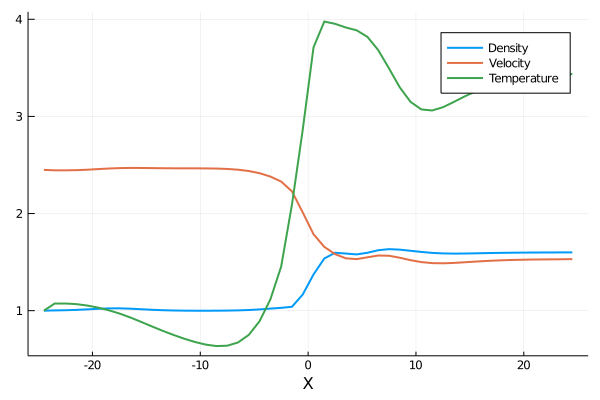

In [242]:
plot_line(ks, ctr)

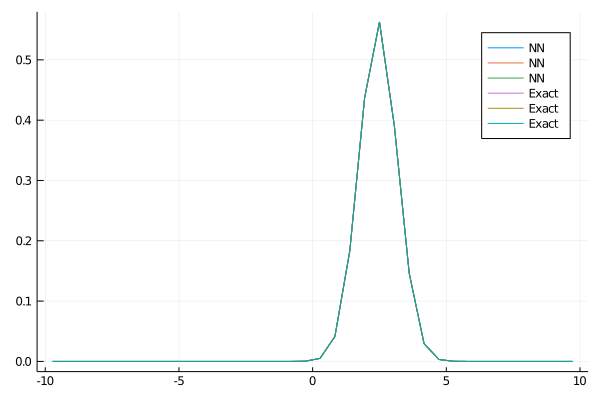

In [158]:
plot(vSpace.u, node(ctr[2].f[1:end], res.minimizer).u, label="NN")
plot!(vSpace.u, Y[:,2,:], label="Exact")

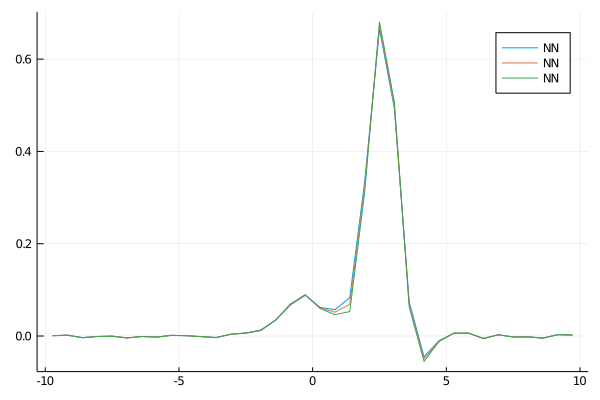

In [244]:
plot(vSpace.u, node(ctr[25].f[1:end], res.minimizer).u, label="NN")

In [142]:
τ

1×50 Array{Float32,2}:
 0.110778  0.110778  0.110778  0.110778  …  0.0373435  0.0373435  0.0373434